# Singular Spectrum Analysis

This notebook demonstrates the steps for Singular Spectrum Analysis (SSA).  It is based on the review article by [Ghil et al. (2002)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2000rg000092), specifically their Section 2.  The original concept of SSA comes from [Broomhead and King, 1986](https://doi.org/10.1016/0167-2789(86)90031-X) and the first application of it in climate science was from [Vautard and Ghil, 1989](https://doi.org/10.1016/0167-2789(89)90077-8)]. Following Ghil et al., in this notebook we'll use the Southern Oscillation Index (SOI) here to demonstrate the process. 

As Ghil et al. (2002) write:

> SSA is designed to extract information from short and noisy time series and thus provide insight into the unknown or only partially known dynamics of the underlying system that generated the series 

[Allen and Smith (1996)](https://doi.org/10.1175/1520-0442(1996)009%3C3373:MCSDIO%3E2.0.CO;2) describe SSA in this way:

> Singular spectrum analysis (SSA) is based on the idea of sliding a window down a time series and looking for patterns that account for a high proportion of the variance in the views of the series thus obtained. SSA is closely related to the standard meteorological technique of empirical orthogonal function analysis 

Whereas in our previous applications of EOF techniques to our data we used the temporal covariance between data at different locations in 'space' (with an expansive understanding of 'space' beyond the Euclidean), in (single channel) SSA we used the lagged covariance of a time series _with itself_ as our basis for quantifying covariance.  There are also some additional steps because the focus of our method here is the lagged covariance matrix of a time series, not the time series itself.  But you will recognize most of the techniques.

Ultimately, we seek to extract important patterns of _self-similarity_  a time series.  These patterns can be thought of as cycles or (quasi) periodic components of our time series analagous to how traditional spectral analysis uses sine and cosine waves.  Here though -- and again similar to EOF analyses on time-space fields -- we will let the covariance of the data form the empirical basis for the extraction of spectral modes of variability. 

Let's get started:


In [217]:
import math
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

We will once again use the Southern Oscillation Index (SOI) (see here: https://crudata.uea.ac.uk/cru/data/soi/), the normalized pressure difference between Tahiti and Darwin, Australia (see also: https://doi.org/10.1175/1520-0493(1987)115%3C2161:AEOTTS%3E2.0.CO;2).  Ghil et al. (2002) use the same index, although ours extends both further in the past and comes to our current present, and so is longer than that used in their 2002 manuscript.  We've used this data series before (notably on Homework #5).  We can read it in here.  This time we will use the monthly data directly and not simply form a seasonal winter mean value.


In [205]:
# read in the soi index as a DataSet
soi = xr.open_dataset("soi.nc",mask_and_scale=True,decode_times=False)

# check the units used for the DataSet
# print(soi["time"].attrs["units"]) # this reveals the units to be 'months since 1866-1-15'

## Because 'months' are not a well-defined thing, we need to change the time coordinate if we want to use xr.corr
# create a new monthly-resolution date range starting with the datum and make it as long as the current time coordinate
new_time = pd.date_range(start='1/01/1866',periods=len(soi["time"]),freq='M')

# apply this new time coordinate to our dataset in place of the old one
soi["time"]=pd.to_datetime(new_time)

# remove the SOI from the DataSet into a DataArray - not sure why this is necessary but seems to be for this to work? 
soi = soi["SOI"]

# final step - ensure that the time coordinate is year and month and that everything else is default
soi["time"] = pd.to_datetime(soi["time"].dt.strftime("%Y-%m"))
soi = soi.dropna(dim="time")

soi_ = soi.to_numpy()


Since we've previously used a seasonal mean, let's take a look at the monthly time series as a sanity check:

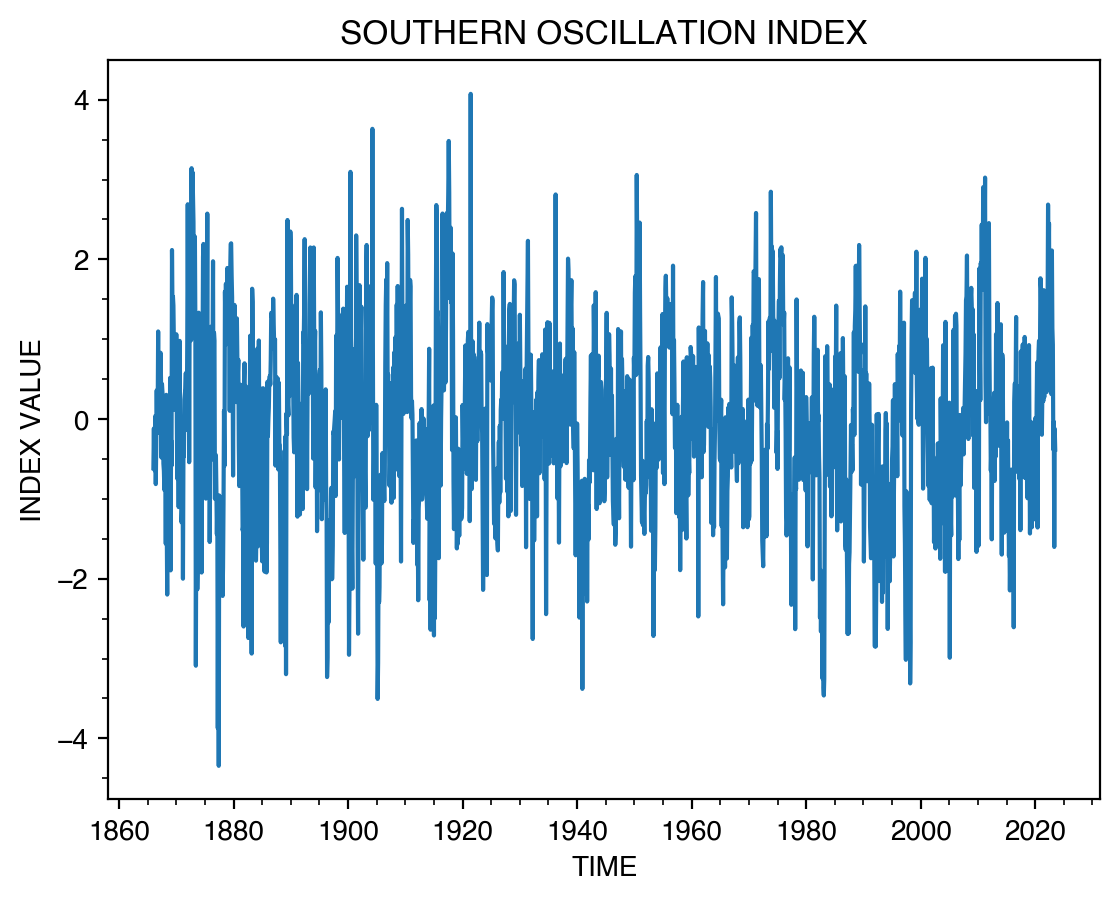

In [206]:
plt.plot(soi.time,soi_)
plt.xlabel("TIME")
plt.ylabel("INDEX VALUE")
plt.title("SOUTHERN OSCILLATION INDEX")
plt.minorticks_on()

For some (other) time series, at this point we might want to remove the annual cycle to focus on the anomalies from that highly repetitive structure, but here we can see ve that little evidence for an _annual_ cycle is present (which is by construction, https://doi.org/10.1175/1520-0493(1987)115%3C2161:AEOTTS%3E2.0.CO;2).  So, we're now ready to do the SSA.

### Do the singular spectrum analysis

The SSA proceeds as follows:  First we will center (in this case, we will calculate a z-score) the time series.  We will record its length to use later and we will specify the width of the window $M$ -- also called the _embedding dimension_ -- we will use to construct the lagged covariance matrix -- the _trajectory matrix_.  As Ghil et al. (2002) write:

> The choice of M is based on a trade-off between two considerations: quantity of information extracted versus the degree of statistical confidence in that information. The former requires as wide a window as possible, i.e., a large M, while the latter requires as many repetitions of the features of interest as possible, i.e., as large a ratio N/M as possible. 

Since our SOI time series is much longer than the length of the index used by Ghil et al., we'll elect to use $M=120$ months, but we can test the sensitivity of our results (and any inference we draw from them) by changing the value of $M$ and performing the analysis again. 

We then construct the trajectory matrix $D$ using windowed lagged copies of the SOI time series.  As Ghil et al. (2002) write:

> The starting point of SSA is to embed a time series {X(t):t = 1, ... , N} in a vector space of dimension M, i.e., to represent it as a trajectory in the phase space of the hypothetical system that generated {X(t)}. In concrete terms this is equivalent to representing the behavior of the system by a succession of overlapping “views” of the series through a sliding M-point window.

In this notebook we calculate the covariance matrix of the trajectory matrix (effectively, the covariance of every windowed section of the time series with every other windowed section of the time series) and it is on this covariance matrix $C$ we perform the SVD. Note that the convention in Ghil et al. (2002) has us use the row-wise covariance that is the default for the Numpy covariance function.  We then project the eigenvectors from the SVD onto the trajectory matrix to get the scores.  The next step is to calculate the Reconstructed Components $RC$ by convolving the eigenvectors and the scores, which yields new time series that are the same length as the original and can be compared directly with it.  These RCs are then scaled following guidelines in Ghil et al. (2002).

In [241]:
# We'll take the z-score, but alternatively you could just remove the mean
ts = sp.stats.zscore(soi_)

# ts = soi_
# ts = ts-np.mean(ts)

# record the length of the time series for later
N = len(ts)

# select the embedding dimension
M = 120  

# Create an empty trajectory matrix
D = np.empty((M, N - M + 1)) 

# fill the trajectory matrix, see Ghil et al. 2022, equation 5 (and equation 6)
for i in range(M):
    D[i, :] = ts[i:N - M + 1 + i]

# Calculate the covariance matrix from the trajectory matrix, see Ghil et al. 2002, equations 6 and 7
C = np.cov(D,ddof=1) # in this case, the row-based default of numpy's covariance is correct

# Calculate the singular value decomposition of the M by M covariance matrix, see Ghil et al. 2002, equations 8 and 9
U, S, Vt = np.linalg.svd(C,full_matrices=False)

# Get eigenvalues and fraction variance explained
eval = S
varexp = 100 * (eval / np.sum(eval))

# Form the signals as the matrix A, see Ghil et al. 2002, equation 10
A = U.T @ D  # Note that you're multiplying the eigenvectors with the trajectory (not data) matrix

# Initialize Reconstructed Components (RC) matrix
RC = np.empty((M, N))

# Calculate the Reconstructed Components, see Ghil et al. 2002, equation 11 (and equation 52)
for i in range(M):
    RC[i, :] = np.convolve(U[:, i], A[i, :],)[:N]  

# Apply normalization, see Ghil et al. 2002, equation 12
for i in range(N):  
    if 0 <= i < M:  # Adjusted for zero-based indexing
        RC[:, i] *= 1 / (i + 1)  
    elif M - 1 <= i < N - M + 1:  
        RC[:, i] /= M
    else:
        RC[:, i] /= (N - i)  
        
# We might calculate North's Rule of Thumb here aas Ghil et al. do - and see discussion in the caption of Ghil et al. 2002, Figure 3
def northTest(ev, neff):
    error_factor = np.sqrt(2.0 / neff) # the square root scaling using the effective degrees of freedom
    error_range = error_factor * ev # apply the square root scaling to the eigenvalues 
	
    return (error_range) # return the error ranges
        

# pass the eigenvalues as input and use Ghil et al.'s effective N calculation from the caption of their Figure 3
ar1 = np.corrcoef(ts[:-1], ts[1:])[1,0] # simple lag-1 autocorrelation
tau = -(1/math.log(ar1)) # from Ghil et al. 2002, Figure 3
neff = len(ts)/(tau * 1.5) # from Ghil et al. 2002, Figure 3

north_errors = northTest(eval,neff)


Let's take a look at the eigenvalues - we can compare these from our longer SOI and different embedding dimension with Figure 3 in Ghil et al. (2002):

Text(0.5, 0, 'EIGENVALUE RANK')

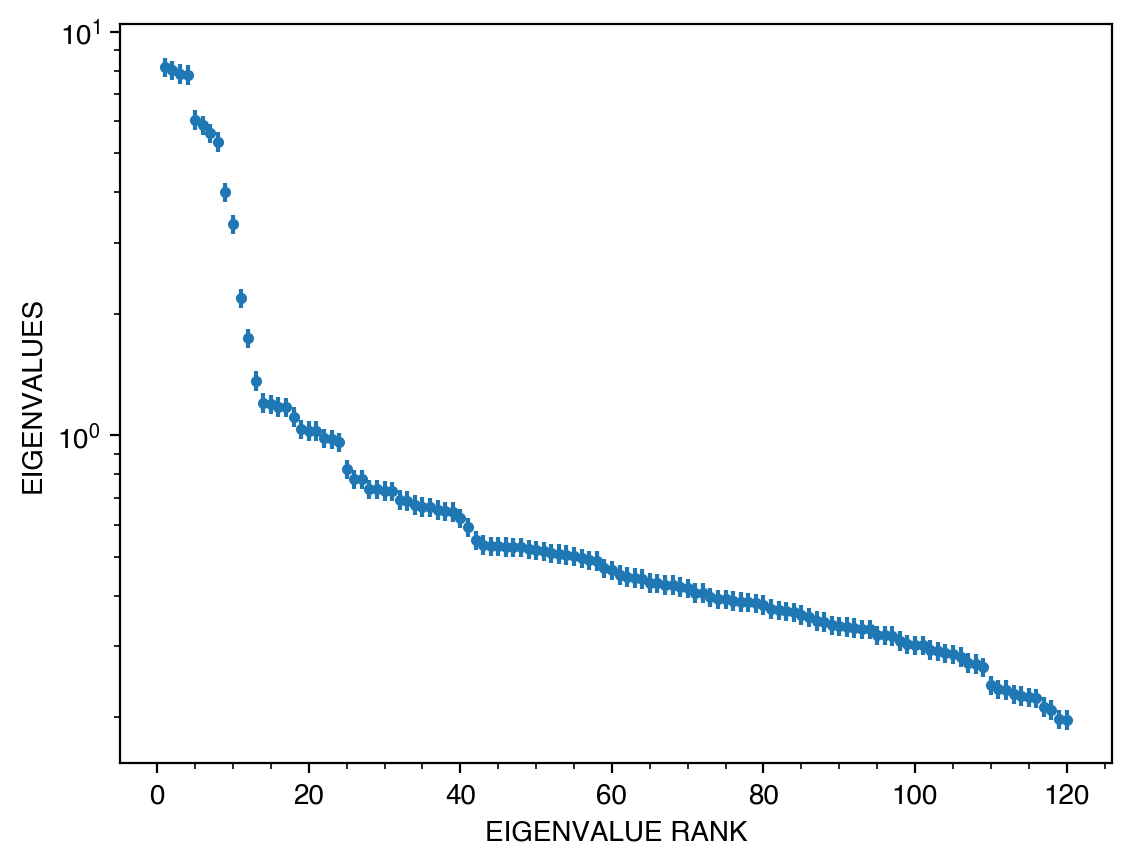

In [242]:
plt.errorbar(np.arange(1,len(eval)+1),eval,yerr=north_errors,linestyle="none",marker=".")
plt.minorticks_on()
plt.yscale("log")
plt.ylabel("EIGENVALUES")
plt.xlabel("EIGENVALUE RANK")

Let's zoom in and look at the structure of the eigenvalues:

Text(0.5, 0, 'EIGENVALUE RANK')

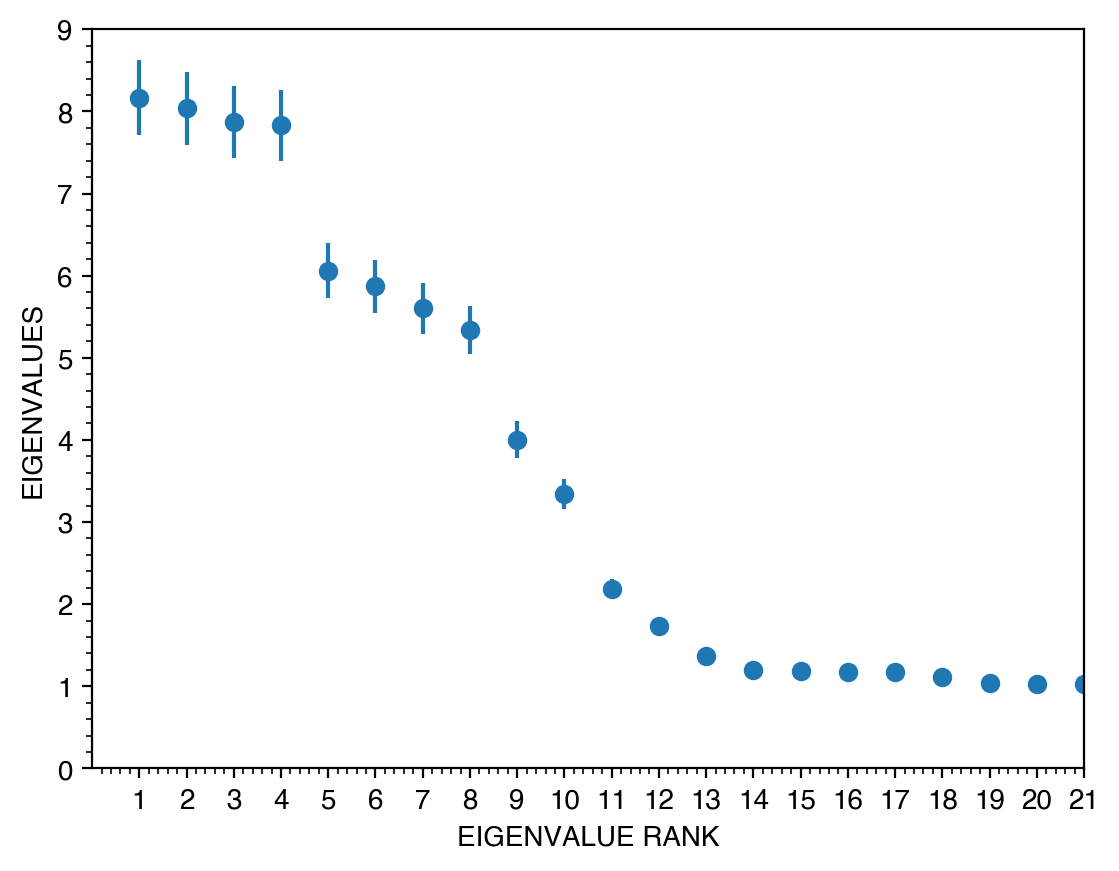

In [243]:
plt.errorbar(np.arange(1,len(eval)+1),eval,yerr=north_errors,linestyle="none",marker="o")
plt.xlim(0,21)
plt.ylim(0,9)
plt.minorticks_on()
plt.xticks(np.arange(1,22));
plt.ylabel("EIGENVALUES")
plt.xlabel("EIGENVALUE RANK")

Note that the low order modes cluster in eigenvalue space.  As we'll see in a moment, some of these modes have very similar eigenvectors, reconstructed components, and dominant frequencies.

### Eigenvectors of the trajectory matrix

The eigenvectors have the length of the embedding dimension, and are typically smooth and/or oscillatory patterns.  You'll notice that in many cases the consecutive eigenvalues have similar magnitudes, and this is because the modes we've extracted often occur _in quadrature_, with the eigenvectors out-of-phase by a predictable (one quarter of a cycle) amount. 


Text(0.5, 0, 'LAG (MONTHS)')

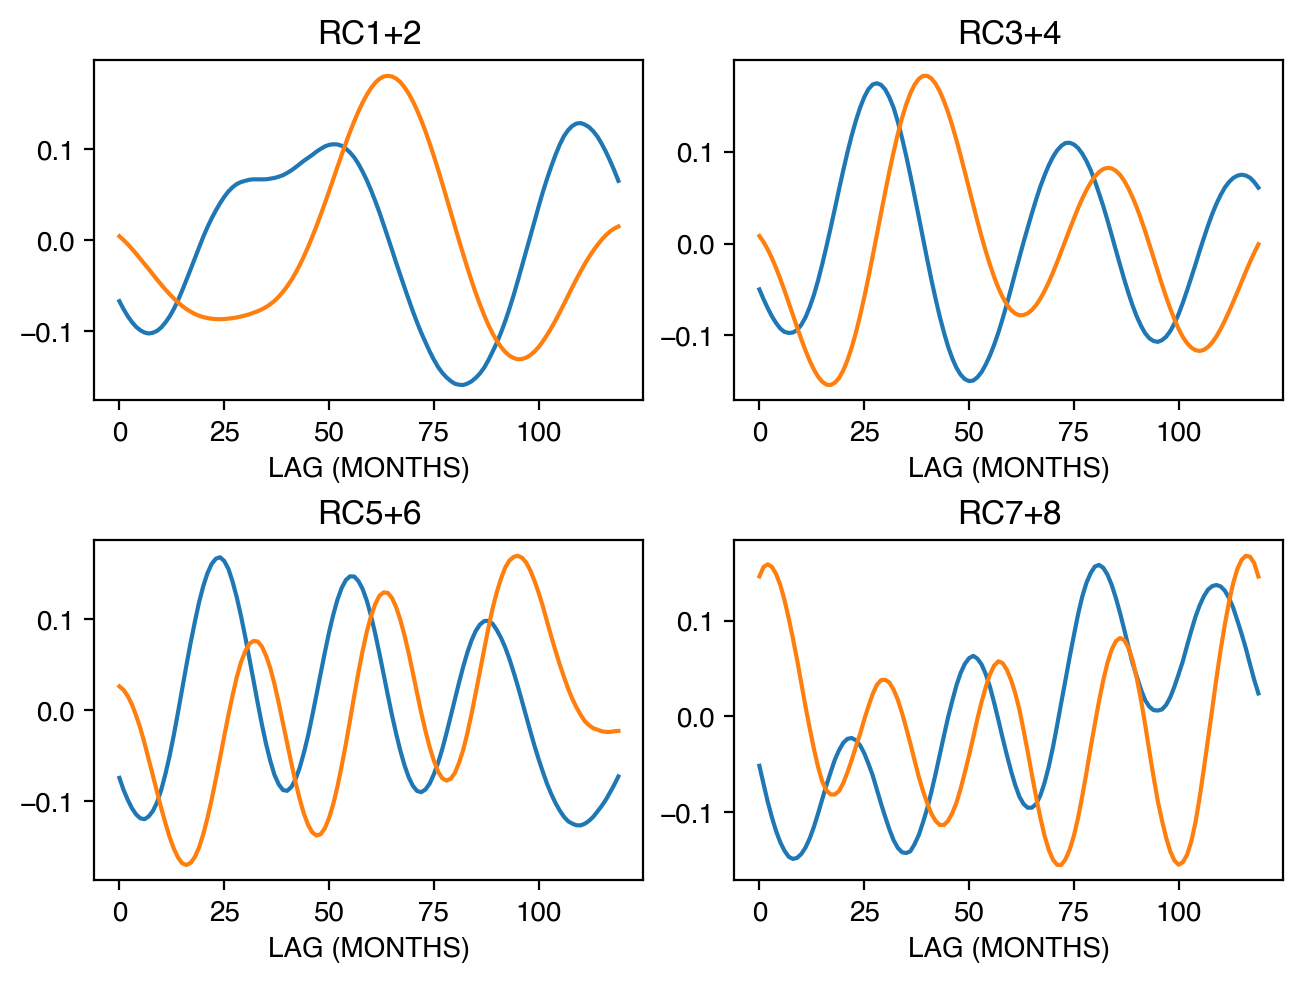

In [237]:
fig, axs = plt.subplots(clear=True,nrows=2,ncols=2,layout="constrained")

axs[0,0].plot(U[:,[0,1]])
axs[0,0].set_title("RC1+2")
axs[0,0].set_xlabel('LAG (MONTHS)')

axs[0,1].plot(U[:,[2,3]])
axs[0,1].set_title("RC3+4")
axs[0,1].set_xlabel('LAG (MONTHS)')

axs[1,0].plot(U[:,[4,5]])
axs[1,0].set_title("RC5+6")
axs[1,0].set_xlabel('LAG (MONTHS)')

axs[1,1].plot(U[:,[6,7]])
axs[1,1].set_title("RC7+8")
axs[1,1].set_xlabel('LAG (MONTHS)')



As I discussed in class, some of these 'pairs' clearly are in quadrature (e.g. RC3 and RC4), others have similar behavior, and others (RC7 and 8) seem different in important ways.  

### Reconstructed components of the time series

Let's plot our new time series -- the Reconstructed Components.  Note that since `soi` has a time dimension in datetime64n format, it is difficult to control (e.g. the units of the datetime coordinate are in nanoseconds) by more conventional means.  But Matplotlib has some functionality to help us.  Specifically we'll us `set_major_locator` and `set_major_formatter` to limit the number and temporal resolution of the x-axis.  For details on how the `dates` functionality works more generally in Matplotlib, see https://matplotlib.org/stable/api/dates_api.html.

Text(0.5, 1.0, 'RC7+8')

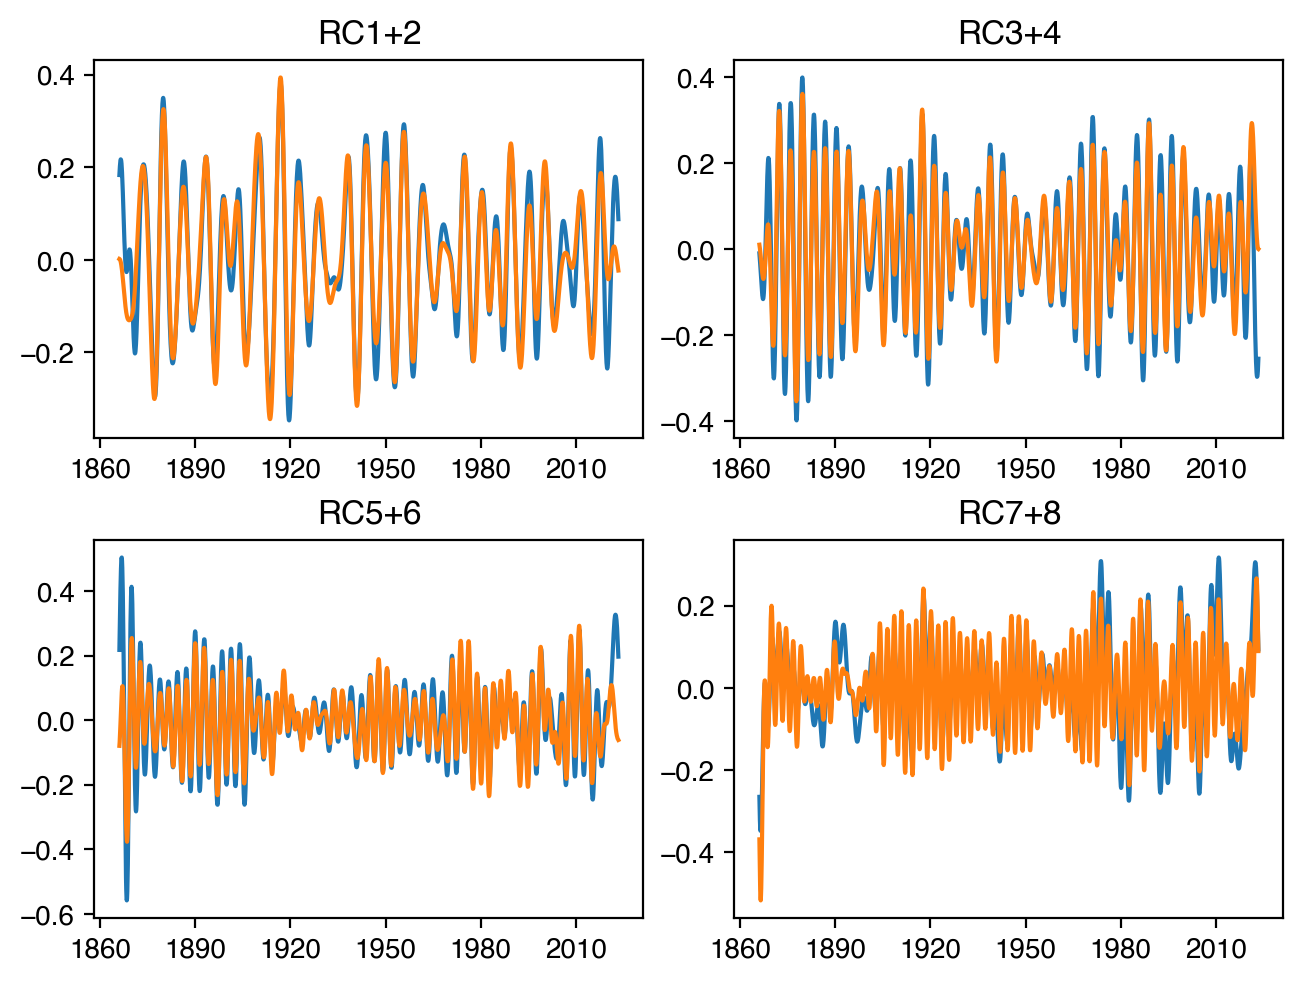

In [211]:
import matplotlib.dates as mdates # we're going to use the dates functionality to format the time axis

fig, axs = plt.subplots(clear=True,nrows=2,ncols=2,layout="constrained")

axs[0,0].plot(soi.time,RC[[0,1],:].T)
axs[0,0].xaxis.set_major_locator(mdates.YearLocator(30))
axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axs[0,0].set_title("RC1+2")

axs[0,1].plot(soi.time,RC[[2,3],:].T)
axs[0,1].xaxis.set_major_locator(mdates.YearLocator(30))
axs[0,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axs[0,1].set_title("RC3+4")

axs[1,0].plot(soi.time,RC[[4,5],:].T)
axs[1,0].xaxis.set_major_locator(mdates.YearLocator(30))
axs[1,0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axs[1,0].set_title("RC5+6")

axs[1,1].plot(soi.time,RC[[6,7],:].T)
axs[1,1].xaxis.set_major_locator(mdates.YearLocator(30))
axs[1,1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
axs[1,1].set_title("RC7+8")

# alternatively, you can auto-format, but this provides less direct control: https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.autofmt_xdate
# plt.gcf().autofmt_xdate()



### Spectra of the Reconstructed Components

Both the eigenvector plots and the Reconstructed Components show periodic behavior.  If we want to know the frequency (or period) of these modes, we can use the periodogram from `scipy.signal` to estimate it.  In the plots below, we show 2 complementary x axes - one for 'months per cycle' (the bottom axis) and one for 'years per cycle' (the top axis) -- using [`secondary_xaxis`](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/secondary_axis.html#sphx-glr-gallery-subplots-axes-and-figures-secondary-axis-py) from Matplotlib. 

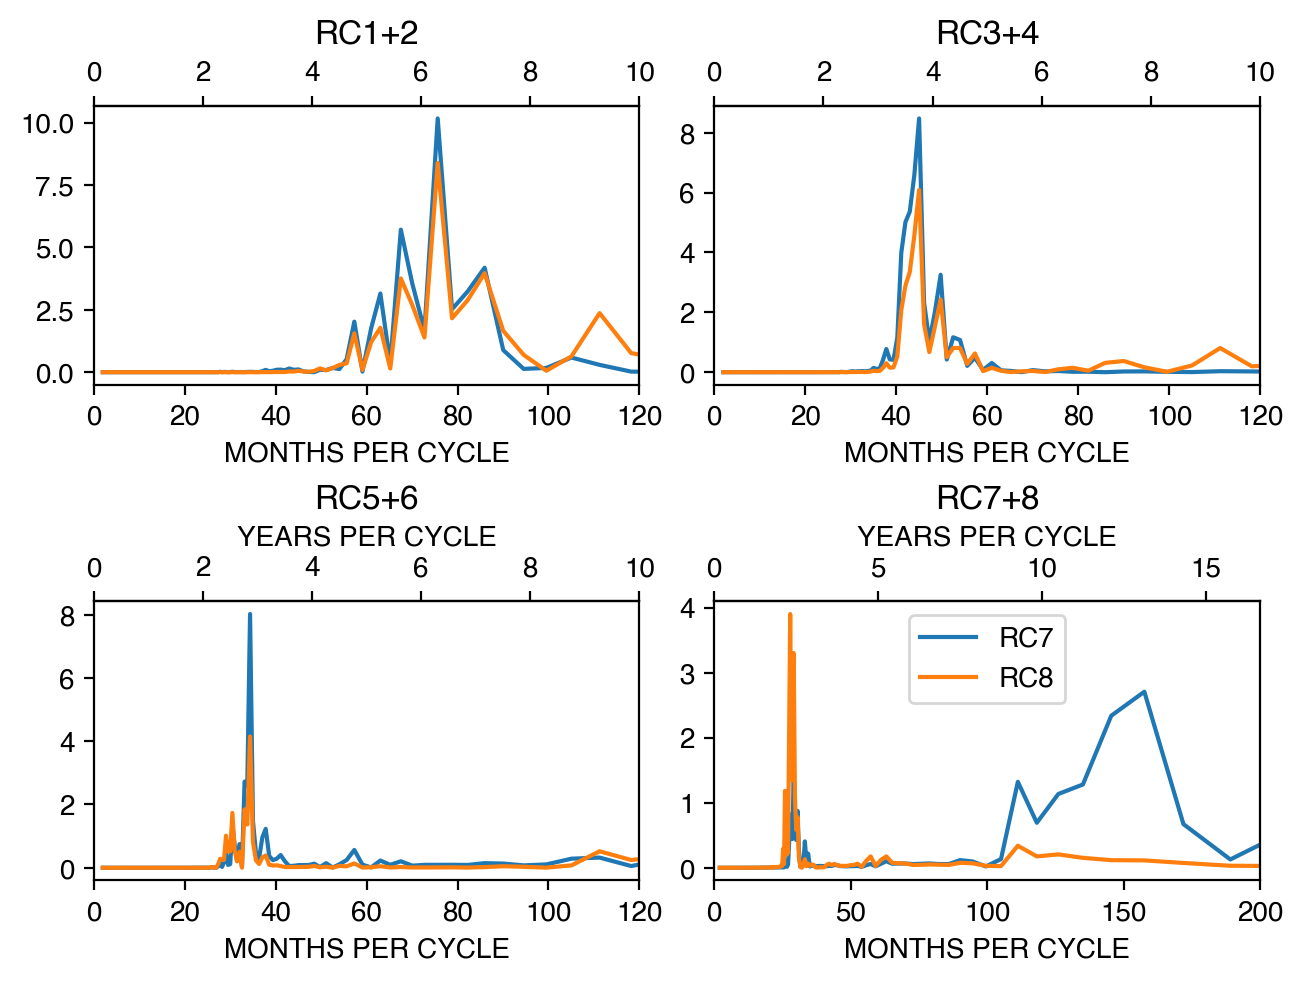

In [212]:
from scipy.signal import periodogram # Scipy has a simple periodogram function

def mtoy(x):
    return x/12 

def ytom(x):
    return x * 12


fig, axs = plt.subplots(clear=True,nrows=2,ncols=2,layout="constrained")

# RC 1 and 2
f1, Pxx1 = periodogram(RC[0,:]) 
f2, Pxx2 = periodogram(RC[1,:]) 

f1 = np.delete(f1, 0) # remove the zero-th power
Pxx1 = np.delete(Pxx1, 0) # remove the zero-th power
f2 = np.delete(f2, 0) # remove the zero-th power
Pxx2 = np.delete(Pxx2, 0) # remove the zero-th power

axs[0,0].plot(1/f1,Pxx1)
axs[0,0].plot(1/f2,Pxx2)
axs[0,0].set_xlim(0,120)
axs[0,0].set_xlabel('MONTHS PER CYCLE')
axs[0,0].set_title("RC1+2")
axs[0,0].secondary_xaxis('top', functions=(mtoy, ytom))

# RC 3 and 4
f1, Pxx1 = periodogram(RC[2,:]) 
f2, Pxx2 = periodogram(RC[3,:]) 

f1 = np.delete(f1, 0) # remove the zero-th power
Pxx1 = np.delete(Pxx1, 0) # remove the zero-th power
f2 = np.delete(f2, 0) # remove the zero-th power
Pxx2 = np.delete(Pxx2, 0) # remove the zero-th power

axs[0,1].plot(1/f1,Pxx1)
axs[0,1].plot(1/f2,Pxx2)
axs[0,1].set_xlim(0,120)
axs[0,1].set_xlabel('MONTHS PER CYCLE')
axs[0,1].set_title("RC3+4")
axs[0,1].secondary_xaxis('top', functions=(mtoy, ytom))

# RC 5 and 6
f1, Pxx1 = periodogram(RC[4,:]) 
f2, Pxx2 = periodogram(RC[5,:]) 

f1 = np.delete(f1, 0) # remove the zero-th power
Pxx1 = np.delete(Pxx1, 0) # remove the zero-th power
f2 = np.delete(f2, 0) # remove the zero-th power
Pxx2 = np.delete(Pxx2, 0) # remove the zero-th power

axs[1,0].plot(1/f1,Pxx1)
axs[1,0].plot(1/f2,Pxx2)
axs[1,0].set_xlim(0,120)
axs[1,0].set_xlabel('MONTHS PER CYCLE')
axs[1,0].set_title("RC5+6")
secax = axs[1,0].secondary_xaxis('top', functions=(mtoy, ytom))
secax.set_xlabel('YEARS PER CYCLE')

# RC 7 and 8
f1, Pxx1 = periodogram(RC[6,:]) 
f2, Pxx2 = periodogram(RC[7,:]) 

f1 = np.delete(f1, 0) # remove the zero-th power
Pxx1 = np.delete(Pxx1, 0) # remove the zero-th power
f2 = np.delete(f2, 0) # remove the zero-th power
Pxx2 = np.delete(Pxx2, 0) # remove the zero-th power

axs[1,1].plot(1/f1,Pxx1,label='RC7')
axs[1,1].plot(1/f2,Pxx2,label='RC8')
axs[1,1].set_xlim(0,200)
axs[1,1].set_xlabel('MONTHS PER CYCLE')
axs[1,1].set_title("RC7+8")
secax = axs[1,1].secondary_xaxis('top', functions=(mtoy, ytom))
secax.set_xlabel('YEARS PER CYCLE')

axs[1,1].legend()



Observe a few things.  First, unlike the sine and cosine examples we looked at earlier, the spectra here show power at adjacent frequencies (instead of a single peak).  Still, most of them have a single dominant frequency in a relatively narrow band.  However, look at RC7, which has a broad secondary peak at a lower frequency between ~10 and 15 years. 

At least for RC1-6, we can quantify the periodic behavior of these modes (collectively between 2.8 and 7 years), where as RC7 has two peaks, one which it shares with RC8 near 2 years. If we wanted to get the frequency of maximum power for all of our modes, we can do so with the loop below and plot that primary period (in years) for each. 

Text(0, 0.5, 'PERIODICITY (YEARS)')

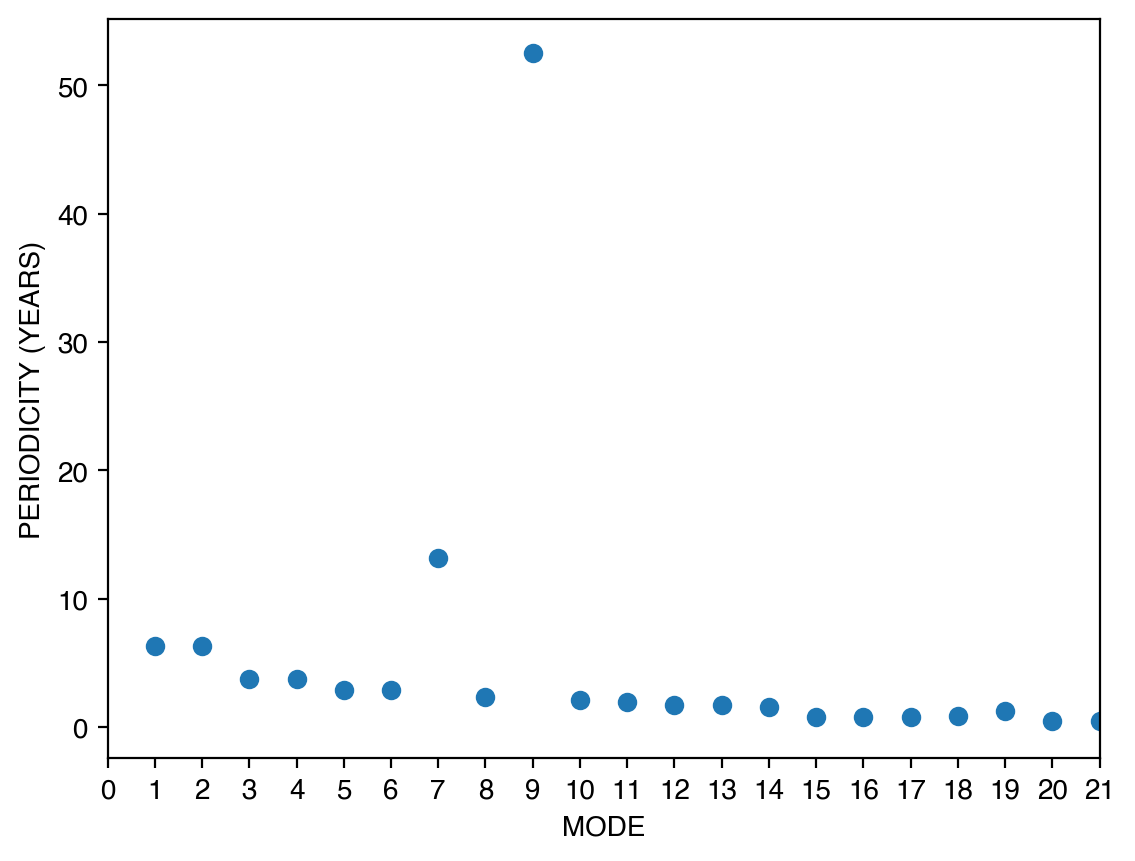

In [244]:
max_frequencies = np.full(RC.shape[0],np.nan)

# Iterate over each row (time series) in the matrix RC
for idx, row in enumerate(RC):
    # Calculate the periodogram
    frequencies, power_density = periodogram(row)

    # Find the index of the maximum value in the power spectral density array
    max_index = np.argmax(power_density)

    # Get the frequency corresponding to the maximum power spectral density value
    max_freq = frequencies[max_index]

    # Assign this frequency to the corresponding index in the max_frequencies array
    max_frequencies[idx] = max_freq


plt.plot(np.arange(len(eval))+1,(1/max_frequencies)/12,marker="o",linestyle="none") # express as period in years
plt.xlim(0,21)
plt.xticks(np.arange(0,22));
plt.xlabel('MODE')
plt.ylabel('PERIODICITY (YEARS)')


For the leading modes, we see more or less what we might expect from the spectra above - the first 6 have periodicities between 2 and 7 years, while RC7 shows the decadal-peak we observed in the plots above as the dominant one.  Most of the higher order modes are between 1 and 2 years, but RC9 has multidecadal power!  What does it look like? 

Text(0.5, 1.0, 'RC9')

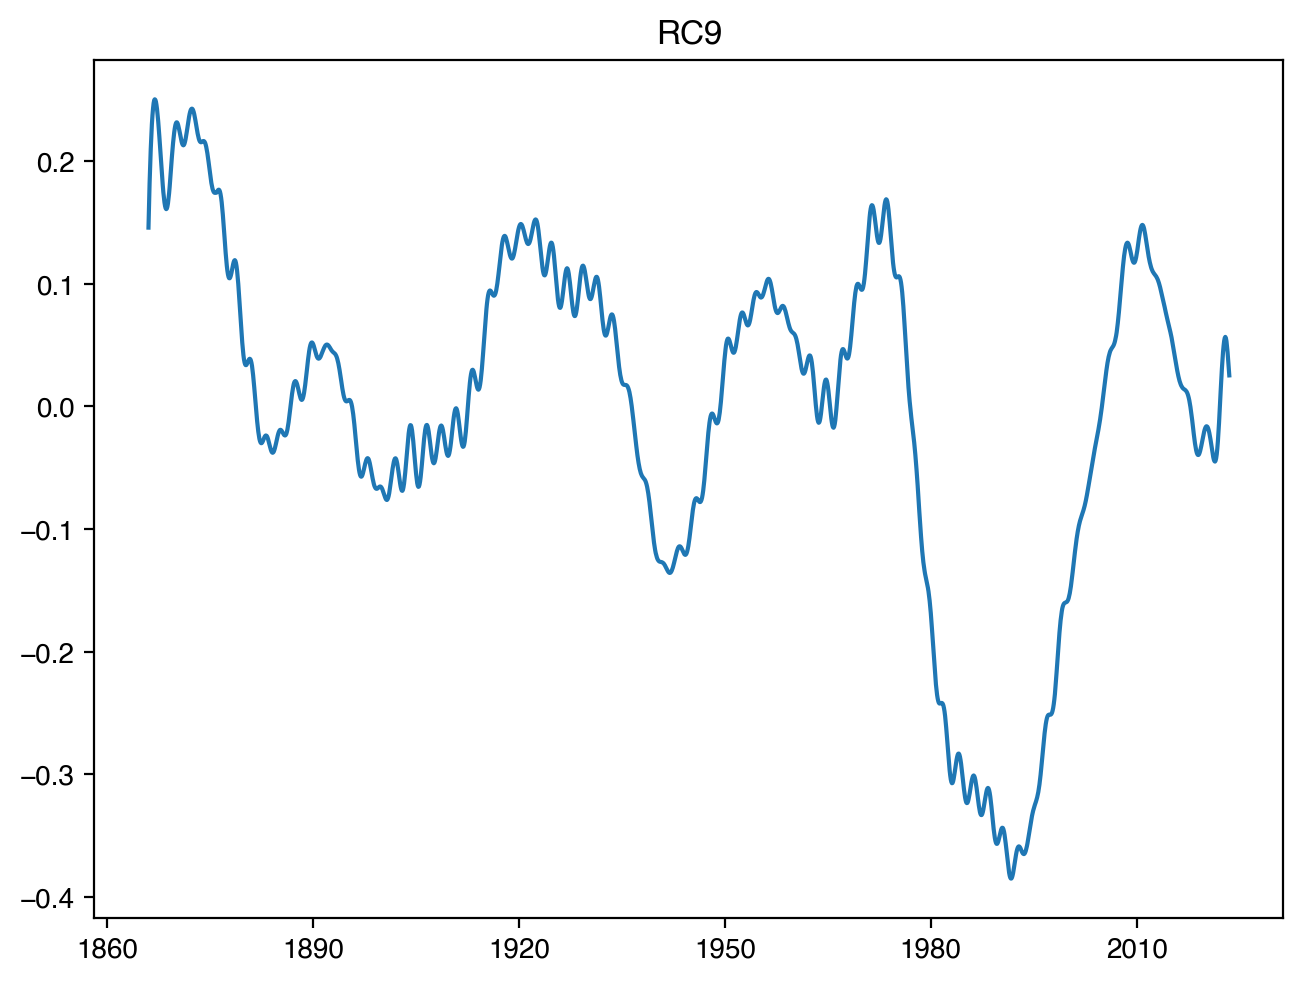

In [214]:
fig, ax1 = plt.subplots(clear=True,nrows=1,ncols=1,layout="constrained")

ax1.plot(soi.time,RC[[8],:].T)
ax1.xaxis.set_major_locator(mdates.YearLocator(30))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax1.set_title("RC9")

Indeed, this mode has low frequency oscillations, but note the scale of these, which is relatively small.

### The reduced space of the original time series

One of the cool things about RCs is we can add them together to assemble reduced or filtered versions of our original time series.  For instance, it appears the first 6 modes at least not only have relatively large eigenvalues but also coherent and relatively narrow-band spectral power (and indeed their dominant frequencies between 2.8 and 7 is what we would expect for ENSO).  We could add these leading modes together to give us a new time series, in the units of the original data series, which captures just these wavelengths:

Text(0, 0.5, 'INDEX')

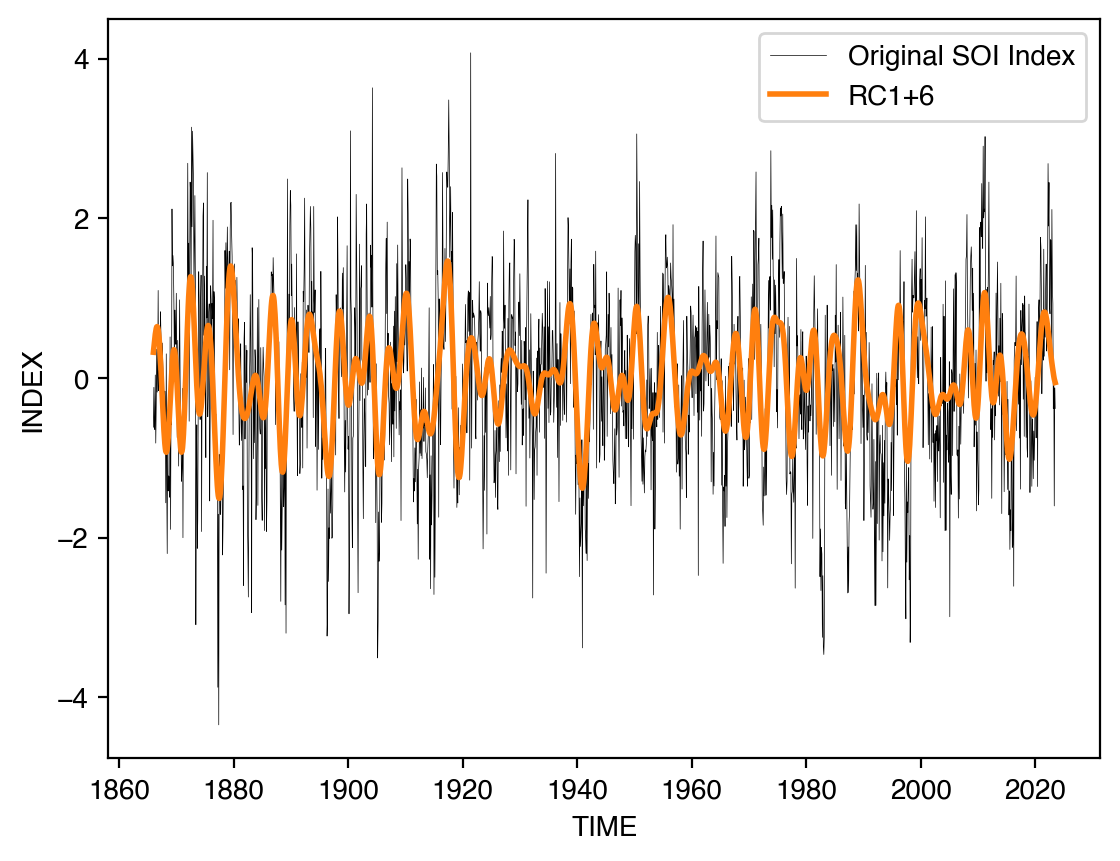

In [215]:
plt.plot()
plt.plot(soi["time"],soi_,color="k",linewidth=0.25,label="Original SOI Index")
plt.plot(soi["time"],np.sum(RC[0:6,:],axis=0),color="tab:orange",linewidth=2,label="RC1+6")
plt.legend()
plt.xlabel("TIME")
plt.ylabel("INDEX")


We could put RC9 on the plot too (or alternatively add it to the others) - you can see that its amplitude is relatively small, however:

Text(0, 0.5, 'INDEX')

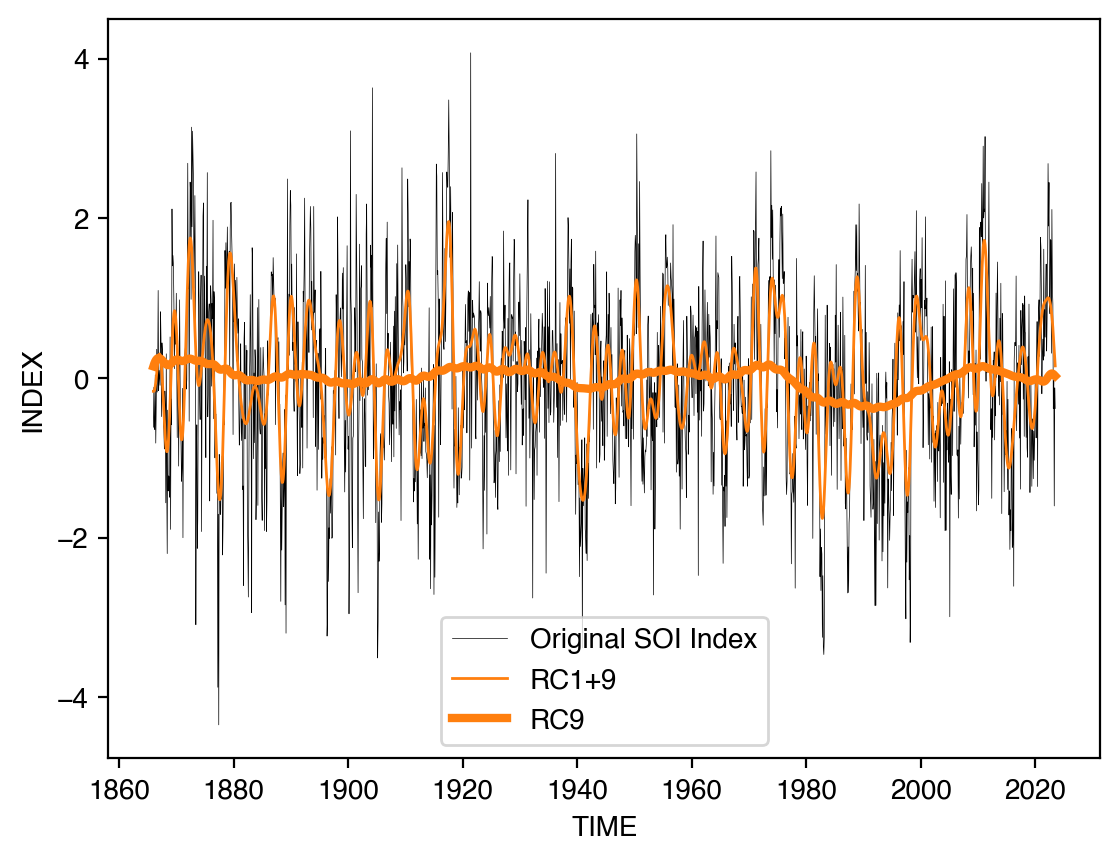

In [216]:
plt.plot()
plt.plot(soi["time"],soi_,color="k",linewidth=0.25,label="Original SOI Index")
plt.plot(soi["time"],np.sum(RC[0:9,:],axis=0),color="tab:orange",linewidth=1,label="RC1+9")
plt.plot(soi["time"],RC[8,:],color="tab:orange",linewidth=3,label="RC9")
plt.legend()
plt.xlabel("TIME")
plt.ylabel("INDEX")